# MNIST classification example with TensorFlow

## Needed librairies

In [3]:
import tensorflow as tf
from keras.datasets import mnist
import keras
import numpy as np
import matplotlib.pyplot as plt
tf.reset_default_graph()

In [4]:
tf.__version__

'1.12.0'

## Import the Data

In [5]:
# get mnist data, split between train and test sets
# on GCP
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
# with AXA network
import gzip
import sys
import _pickle as cPickle
def load_data(path):
    f = gzip.open(path, 'rb')
    if sys.version_info < (3,):
        data = cPickle.load(f)
    else:
        data = cPickle.load(f, encoding='bytes')
    f.close()
    return data
(x_train, y_train), (x_test, y_test) = load_data(path='../data/mnist.pkl.gz')

In [6]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [7]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [8]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [9]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

## Normalize and reorganize the data

In [10]:
# cast uint8 -> float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [11]:
# renormalize the data 255 grey variation
x_train /= 255
x_test /= 255

In [12]:
# reshape the data 28 x 28 -> 784
x_train = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

In [13]:
x_train.shape

(60000, 784)

In [14]:
x_test.shape

(10000, 784)

## Reshape the labels

In [15]:
y_train.shape

(60000,)

In [16]:
y_test.shape

(10000,)

In [17]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [18]:
num_classes = len(np.unique(y_train))
num_classes

10

In [19]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [20]:
y_train.shape

(60000, 10)

In [21]:
y_test.shape

(10000, 10)

In [22]:
dim_input=x_train.shape[1]
dim_input

784

## Visualize the data

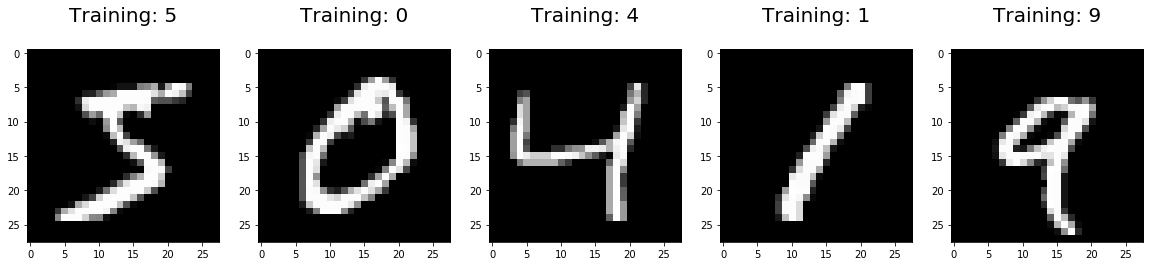

In [23]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % np.argmax(label), fontsize = 20)

## Defined some hyperparameters

In [24]:
# learning rate
learning_rate = 0.5
# number of epoch to train our model
epochs = 10
# size of our mini batch
batch_size = 128
# hidden layer 1
n1=300

## Defined our model

In [25]:
# x [60000, 784]
# y [60000, 10]

# reset graph before starting
tf.reset_default_graph()

# tensor (placeholder) for the learning rate
learning_rate = tf.placeholder(tf.float32, shape=())

# tensor (placeholder) for the input data [60000, 784]
x = tf.placeholder(tf.float32, [None, dim_input])
# tensor (placeholder) for the output data [60000, 10]
y = tf.placeholder(tf.float32, [None, num_classes])

# now declare the weights connecting the input to the hidden layer
W1 = tf.Variable(tf.random_normal([dim_input, n1], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random_normal([n1]), name='b1')
# and the weights connecting the hidden layer to the output layer
W2 = tf.Variable(tf.random_normal([n1, num_classes], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random_normal([num_classes]), name='b2')

# calculate the output of the hidden layer
hidden_out = tf.add(tf.matmul(x, W1), b1)
hidden_out = tf.nn.relu(hidden_out)

# now calculate the hidden layer output - in this case, let's use a softmax activated
# output layer
y_ = tf.nn.softmax(tf.add(tf.matmul(hidden_out, W2), b2))

# now let's define the cost function which we are going to train the model on
y_clipped = tf.clip_by_value(y_, 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.log(y_clipped)
                                                  + (1 - y) * tf.log(1 - y_clipped), axis=1))

# add an optimiser
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

# finally setup the initialisation operator
init= tf.global_variables_initializer()

# define an accuracy assessment operation
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [26]:
# add a summary to store the accuracy
tf.summary.scalar('accuracy', accuracy)

merged = tf.summary.merge_all()
writer = tf.summary.FileWriter('../results/TensorBoard/mnist')

In [27]:
def run_logistic_model(learning_r, training_epochs, train_obs, train_labels, test_obs, test_labels, debug = False):
    sess = tf.Session()
    sess.run(init)
    
    writer = tf.summary.FileWriter("../results/TensorBoard/mnist", sess.graph)
    
    cost_history = np.empty(shape=[0], dtype = float)

    for epoch in range(training_epochs+1):
        
        sess.run(optimiser, feed_dict = {x: train_obs, y: train_labels, learning_rate: learning_r})

        cost_ = sess.run(cross_entropy, feed_dict={x: train_obs, y: train_labels, learning_rate: learning_r})
        cost_history = np.append(cost_history, cost_)
        
        if (epoch % 100 == 0) & debug:
            print("Reached epoch",epoch,"cost J =", str.format('{0:.6f}', cost_))
            acc_train = sess.run(accuracy, feed_dict={x: train_obs, y: train_labels})
            acc_test = sess.run(accuracy, feed_dict={x: test_obs, y: test_labels})
            print(" accurary on the training set", str.format('{0:.2f}', acc_train))
            print(" accurary on the testing set", str.format('{0:.2f}', acc_test))
        summary = sess.run(merged, feed_dict={x: test_obs, y: test_labels})
        writer.add_summary(summary, epoch)
    print("\nTraining complete!")
    writer.add_graph(sess.graph)
    return sess, cost_history

In [28]:
sess, cost_history = run_logistic_model(learning_r = 0.01, 
                                        training_epochs = 300, 
                                        train_obs = x_train, 
                                        train_labels = y_train, 
                                        test_obs = x_test, 
                                        test_labels = y_test, 
                                        debug = True)

Reached epoch 0 cost J = 3.478295
 accurary on the training set 0.11
 accurary on the testing set 0.11
Reached epoch 100 cost J = 2.864599
 accurary on the training set 0.61
 accurary on the testing set 0.61
Reached epoch 200 cost J = 2.348127
 accurary on the training set 0.72
 accurary on the testing set 0.73
Reached epoch 300 cost J = 1.835602
 accurary on the training set 0.78
 accurary on the testing set 0.79

Training complete!


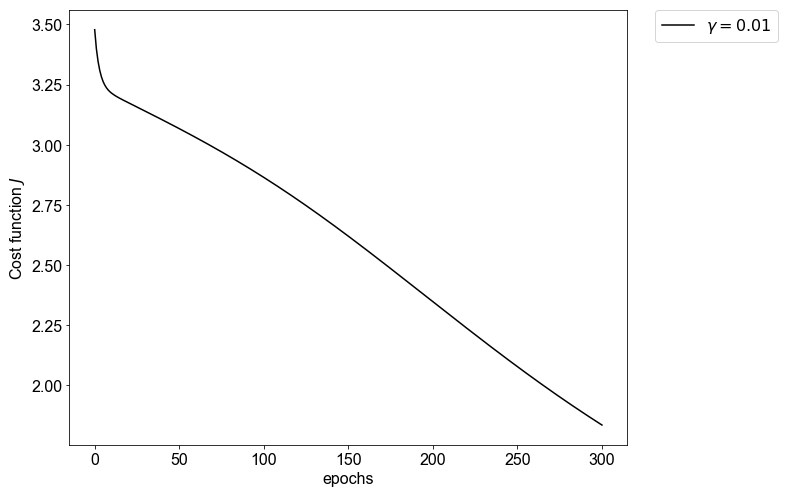

In [29]:
plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(cost_history, ls='solid', color = 'black', label = '$\gamma = 0.01$')
ax.set_xlabel('epochs', fontsize = 16)
ax.set_ylabel('Cost function $J$', fontsize = 16)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 16)
plt.tick_params(labelsize=16);

In [33]:
acc_train = sess.run(accuracy, feed_dict={x: x_train, y: y_train})
acc_test = sess.run(accuracy, feed_dict={x: x_test, y: y_test})
print(" accurary on the training set", str.format('{0:.2f}', acc_train))
print(" accurary on the testing set", str.format('{0:.2f}', acc_test))

 accurary on the training set 0.78
 accurary on the testing set 0.79
